Folder: /content/dataset
 Subfolders: ['heart_dataset']
 Files: []
--------------------------------------------------
Folder: /content/dataset/heart_dataset
 Subfolders: ['labels', 'images']
 Files: []
--------------------------------------------------
Folder: /content/dataset/heart_dataset/labels
 Subfolders: ['train', 'val']
 Files: []
--------------------------------------------------
Folder: /content/dataset/heart_dataset/labels/train
 Subfolders: []
 Files: ['original_2D_01_1938_jpg.rf.92754db231d5182428457712cc035921.txt', 'original_2D_01_132_jpg.rf.f8c8a93f457dd9d7ee18b5bc6b46bce8.txt', 'original_2D_01_0133_jpg.rf.c2bf9f86d0a02daaadcc4898ba7304c6.txt', 'original_2D_01_1852_jpg.rf.95490b30fe1a61aa22f3189c4480c4e3.txt', 'original_2D_01_1935_jpg.rf.9443ba3e46ff860761f5f60d31864471.txt', 'original_2D_01_2341_jpg.rf.88ae5dfba4105dec0a10afc096ad3ff0.txt', 'original_2D_01_2233_jpg.rf.78659d10a3ef81dbaf547c7498d6e952.txt', 'original_2D_01_2518_jpg.rf.708e463c958292815e98fd94a1bd20e6.txt

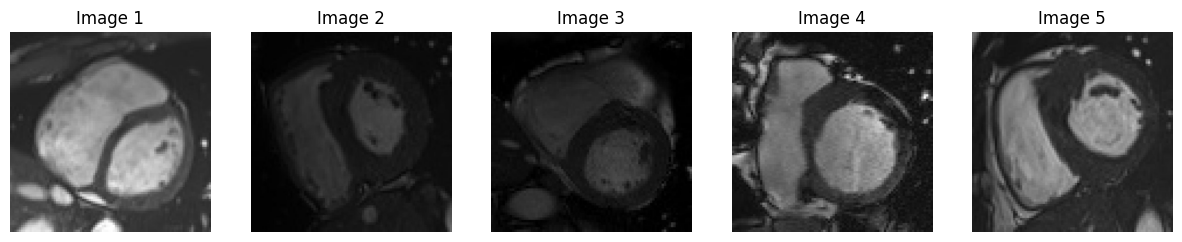

In [ ]:
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the zip file and extraction directory
zip_path = "/content/heart_dataset_sup.zip"
extract_path = "/content/dataset"

# Step 1: Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Step 2: List the contents of the extracted folders
folder_structure = {}
for root, dirs, files in os.walk(extract_path):
    folder_structure[root] = {'dirs': dirs, 'files': files}

# Display the folder structure
for folder, contents in folder_structure.items():
    print(f"Folder: {folder}")
    print(f" Subfolders: {contents['dirs']}")
    print(f" Files: {contents['files']}")
    print("-" * 50)

# Step 3: Find image files and display 5 sample images
image_paths = []
for root, _, files in os.walk(extract_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

# Display the first 5 images
num_images_to_display = min(5, len(image_paths))
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

for i in range(num_images_to_display):
    img = Image.open(image_paths[i])
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Image {i+1}")

plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models import resnet50
import tensorflow as tf
from scipy.integrate import odeint
import matplotlib.pyplot as plt

class SensitivityAnalysis:
    def __init__(self):
        self.results = {}

    def calculate_metrics(self, y_true, y_pred, threshold=0.5):
        """
        Calculate sensitivity, specificity, and precision
        """
        # Convert probabilities to binary predictions
        y_pred_binary = (y_pred >= threshold).astype(int)

        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()

        # Calculate metrics
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0

        return sensitivity, specificity, precision

    def maskrcnn_sensitivity(self, model, test_loader, thresholds):
        """
        Sensitivity analysis for Mask R-CNN model
        """
        results = []
        model.eval()

        with torch.no_grad():
            for threshold in thresholds:
                all_sensitivities = []
                all_specificities = []
                all_precisions = []

                for images, targets in test_loader:
                    predictions = model(images)

                    for pred, target in zip(predictions, targets):
                        # Extract ground truth and predicted masks
                        pred_masks = pred['masks'].squeeze().cpu().numpy()
                        true_masks = target['masks'].squeeze().cpu().numpy()

                        # Calculate metrics for this image
                        sensitivity, specificity, precision = self.calculate_metrics(
                            true_masks.flatten(),
                            pred_masks.flatten(),
                            threshold
                        )

                        all_sensitivities.append(sensitivity)
                        all_specificities.append(specificity)
                        all_precisions.append(precision)

                results.append({
                    'threshold': threshold,
                    'sensitivity': np.mean(all_sensitivities),
                    'specificity': np.mean(all_specificities),
                    'precision': np.mean(all_precisions)
                })

        self.results['maskrcnn'] = results
        return results

    def resnet_sensitivity(self, model, test_loader, thresholds):
        """
        Sensitivity analysis for ResNet model
        """
        results = []
        model.eval()

        with torch.no_grad():
            for threshold in thresholds:
                all_sensitivities = []
                all_specificities = []
                all_precisions = []

                for images, labels in test_loader:
                    outputs = model(images)
                    predictions = torch.sigmoid(outputs)

                    # Calculate metrics
                    sensitivity, specificity, precision = self.calculate_metrics(
                        labels.cpu().numpy(),
                        predictions.cpu().numpy(),
                        threshold
                    )

                    all_sensitivities.append(sensitivity)
                    all_specificities.append(specificity)
                    all_precisions.append(precision)

                results.append({
                    'threshold': threshold,
                    'sensitivity': np.mean(all_sensitivities),
                    'specificity': np.mean(all_specificities),
                    'precision': np.mean(all_precisions)
                })

        self.results['resnet'] = results
        return results

    def yolo_sensitivity(self, model, test_loader, thresholds):
        """
        Sensitivity analysis for YOLO model
        """
        results = []
        model.eval()

        with torch.no_grad():
            for threshold in thresholds:
                all_sensitivities = []
                all_specificities = []
                all_precisions = []

                for images, targets in test_loader:
                    predictions = model(images)

                    for pred, target in zip(predictions, targets):
                        # Extract bounding boxes and confidence scores
                        pred_boxes = pred['boxes'].cpu().numpy()
                        pred_scores = pred['scores'].cpu().numpy()
                        true_boxes = target['boxes'].cpu().numpy()

                        # Filter predictions based on threshold
                        mask = pred_scores >= threshold
                        pred_boxes = pred_boxes[mask]

                        # Calculate IoU matrix
                        ious = self.calculate_iou_matrix(pred_boxes, true_boxes)

                        # Calculate metrics using IoU matches
                        sensitivity, specificity, precision = self.calculate_detection_metrics(
                            ious,
                            iou_threshold=0.5
                        )

                        all_sensitivities.append(sensitivity)
                        all_specificities.append(specificity)
                        all_precisions.append(precision)

                results.append({
                    'threshold': threshold,
                    'sensitivity': np.mean(all_sensitivities),
                    'specificity': np.mean(all_specificities),
                    'precision': np.mean(all_precisions)
                })

        self.results['yolo'] = results
        return results

    def epidemic_model_sensitivity(self, model_type='SIR', params_range=None):
        """
        Sensitivity analysis for epidemic models (SIR and SEIR)
        """
        if params_range is None:
            params_range = {
                'beta': np.linspace(0.2, 0.4, 5),
                'gamma': np.linspace(0.1, 0.3, 5),
                'sigma': np.linspace(0.1, 0.3, 5) if model_type == 'SEIR' else None
            }

        results = []
        t = np.linspace(0, 100, 100)
        N = 1000  # Total population
        initial_conditions = [N-1, 1, 0] if model_type == 'SIR' else [N-1, 0, 1, 0]

        def sir_model(y, t, beta, gamma):
            S, I, R = y
            dSdt = -beta * S * I / N
            dIdt = beta * S * I / N - gamma * I
            dRdt = gamma * I
            return [dSdt, dIdt, dRdt]

        def seir_model(y, t, beta, sigma, gamma):
            S, E, I, R = y
            dSdt = -beta * S * I / N
            dEdt = beta * S * I / N - sigma * E
            dIdt = sigma * E - gamma * I
            dRdt = gamma * I
            return [dSdt, dEdt, dIdt, dRdt]

        for beta in params_range['beta']:
            for gamma in params_range['gamma']:
                if model_type == 'SIR':
                    sol = odeint(sir_model, initial_conditions, t, args=(beta, gamma))
                    max_infected = np.max(sol[:, 1])
                    results.append({
                        'beta': beta,
                        'gamma': gamma,
                        'max_infected': max_infected
                    })
                else:  # SEIR
                    for sigma in params_range['sigma']:
                        sol = odeint(seir_model, initial_conditions, t, args=(beta, sigma, gamma))
                        max_infected = np.max(sol[:, 2])
                        results.append({
                            'beta': beta,
                            'gamma': gamma,
                            'sigma': sigma,
                            'max_infected': max_infected
                        })

        self.results[model_type.lower()] = results
        return results

    def plot_results(self, model_name):
        """
        Plot sensitivity analysis results
        """
        results = self.results.get(model_name.lower())
        if not results:
            print(f"No results found for {model_name}")
            return

        plt.figure(figsize=(10, 6))

        if model_name.lower() in ['maskrcnn', 'resnet', 'yolo']:
            thresholds = [r['threshold'] for r in results]
            sensitivities = [r['sensitivity'] for r in results]
            specificities = [r['specificity'] for r in results]
            precisions = [r['precision'] for r in results]

            plt.plot(thresholds, sensitivities, label='Sensitivity')
            plt.plot(thresholds, specificities, label='Specificity')
            plt.plot(thresholds, precisions, label='Precision')
            plt.xlabel('Threshold')
            plt.ylabel('Metric Value')

        else:  # SIR or SEIR
            betas = sorted(list(set([r['beta'] for r in results])))
            gammas = sorted(list(set([r['gamma'] for r in results])))

            max_infected = np.zeros((len(betas), len(gammas)))
            for i, beta in enumerate(betas):
                for j, gamma in enumerate(gammas):
                    result = next(r for r in results if r['beta'] == beta and r['gamma'] == gamma)
                    max_infected[i, j] = result['max_infected']

            plt.imshow(max_infected, cmap='viridis',
                      extent=[min(gammas), max(gammas), min(betas), max(betas)])
            plt.colorbar(label='Max Infected')
            plt.xlabel('gamma')
            plt.ylabel('beta')

        plt.title(f'Sensitivity Analysis - {model_name}')
        plt.legend()
        plt.grid(True)
        plt.show()

    @staticmethod
    def calculate_iou_matrix(boxes1, boxes2):
        """
        Calculate IoU matrix between two sets of boxes
        """
        def box_area(box):
            return (box[2] - box[0]) * (box[3] - box[1])

        area1 = box_area(boxes1.T)
        area2 = box_area(boxes2.T)

        lt = np.maximum(boxes1[:, None, :2], boxes2[:, :2])
        rb = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])
        wh = np.clip(rb - lt, 0, None)

        inter = wh[:, :, 0] * wh[:, :, 1]
        union = area1[:, None] + area2 - inter

        return inter / union

    @staticmethod
    def calculate_detection_metrics(iou_matrix, iou_threshold=0.5):
        """
        Calculate detection metrics based on IoU matrix
        """
        matches = iou_matrix >= iou_threshold

        tp = np.sum(matches.any(axis=1))
        fp = len(matches) - tp
        fn = np.sum(~matches.any(axis=0))

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = 0  # Not typically used for object detection
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0

        return sensitivity, specificity, precision

In [ ]:
!pip install torch torchvision opencv-python pillow numpy matplotlib

In [ ]:
import os

def inspect_dataset(base_path):
    """
    Function to inspect the dataset structure and content
    """
    print("Inspecting dataset at:", base_path)

    # Check train labels
    train_label_dir = os.path.join(base_path, 'labels', 'train')
    print("\nChecking train labels directory:", train_label_dir)

    if os.path.exists(train_label_dir):
        label_files = os.listdir(train_label_dir)
        print(f"Found {len(label_files)} label files in train directory")

        # Print content of first few label files
        for file_name in label_files[:2]:  # Look at first 2 files
            print(f"\nContent of {file_name}:")
            try:
                with open(os.path.join(train_label_dir, file_name), 'r') as f:
                    content = f.read()
                    print(content)
                    # Print number of values in each line
                    lines = content.strip().split('\n')
                    for i, line in enumerate(lines):
                        values = line.strip().split()
                        print(f"Line {i+1} has {len(values)} values: {values}")
            except Exception as e:
                print(f"Error reading file: {str(e)}")
    else:
        print("Train labels directory not found!")

    # Check val labels
    val_label_dir = os.path.join(base_path, 'labels', 'val')
    print("\nChecking validation labels directory:", val_label_dir)

    if os.path.exists(val_label_dir):
        label_files = os.listdir(val_label_dir)
        print(f"Found {len(label_files)} label files in val directory")

        # Print content of first few label files
        for file_name in label_files[:2]:  # Look at first 2 files
            print(f"\nContent of {file_name}:")
            try:
                with open(os.path.join(val_label_dir, file_name), 'r') as f:
                    content = f.read()
                    print(content)
                    # Print number of values in each line
                    lines = content.strip().split('\n')
                    for i, line in enumerate(lines):
                        values = line.strip().split()
                        print(f"Line {i+1} has {len(values)} values: {values}")
            except Exception as e:
                print(f"Error reading file: {str(e)}")
    else:
        print("Validation labels directory not found!")

# Run the inspection
BASE_PATH = '/content/dataset/heart_dataset/'
inspect_dataset(BASE_PATH)

Inspecting dataset at: /content/dataset/heart_dataset/

Checking train labels directory: /content/dataset/heart_dataset/labels/train
Found 279 label files in train directory

Content of original_2D_01_1938_jpg.rf.92754db231d5182428457712cc035921.txt:
1 0.41338028125 0.7414516124999999 0.447746478125 0.7849999999999999 0.4857746484375 0.82 0.5391549296875 0.8504838703125 0.6039436625 0.854838709375 0.6497183093750001 0.854838709375 0.691690140625 0.8417741937500001 0.691690140625 0.8374193546875001 0.7069014078125 0.8330645156250001 0.75267605625 0.8156451609375001 0.7869014078125 0.793709678125 0.8326760562500001 0.7545161296875 0.8478873234375 0.7108064515625 0.8554929578125 0.64967741875 0.8707042250000001 0.6061290328125 0.8746478874999999 0.5667741937499999 0.8746478874999999 0.518709678125 0.8630985921875001 0.4620967734375 0.8554929578125 0.40967741875 0.8326760562500001 0.3790322578125 0.813661971875 0.3441935484375 0.7830985921875 0.31354838749999997 0.75267605625 0.28306451562

In [ ]:
!pip install torch torchvision ultralytics opencv-python scipy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.3/886.3 kB 16.6 MB/s eta 0:00:00


In [ ]:
import os
from PIL import Image
import torch
from torchvision.transforms import functional as F

# Define dataset paths
image_train_path = '/content/dataset/heart_dataset/images/train'
label_train_path = '/content/dataset/heart_dataset/labels/train'

# Load images and labels
train_images = [os.path.join(image_train_path, img) for img in os.listdir(image_train_path) if img.endswith(('.jpg', '.png'))]
train_labels = [os.path.join(label_train_path, lbl) for lbl in os.listdir(label_train_path) if lbl.endswith('.txt')]

print(f"Loaded {len(train_images)} images and {len(train_labels)} labels.")

Loaded 279 images and 279 labels.


In [ ]:
from torchvision.models.detection import maskrcnn_resnet50_fpn

# Load pre-trained Mask R-CNN
mask_rcnn = maskrcnn_resnet50_fpn(pretrained=True)
mask_rcnn.eval()  # Set to evaluation mode

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
from torchvision.models import resnet18

# Load pre-trained ResNet model
resnet_model = resnet18(pretrained=True)
resnet_model.eval()  # Set to evaluation mode

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Clone the YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17045, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17045 (delta 10), reused 18 (delta 8), pack-reused 17022 (from 1)
Receiving objects: 100% (17045/17045), 15.67 MiB | 28.87 MiB/s, done.
Resolving deltas: 100% (11704/11704), done.
/content/yolov5


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-14 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


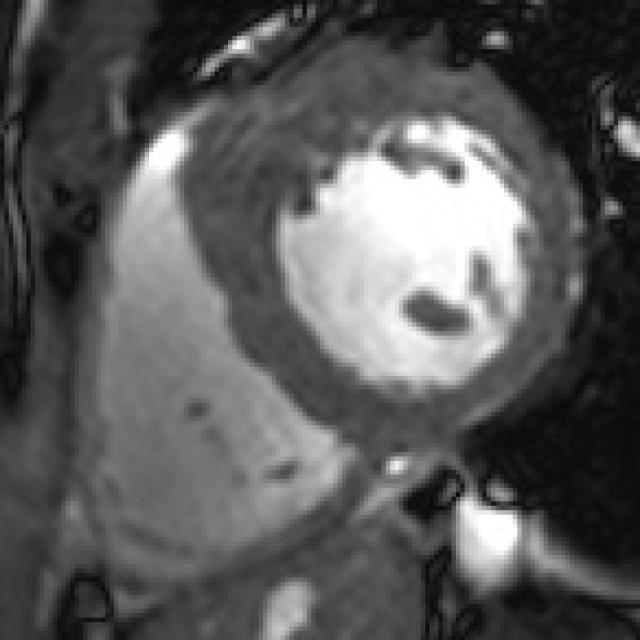

In [ ]:
import torch

# Load the YOLOv5 model directly from the Ultralytics GitHub repository
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Run inference on a sample image
image_path = '/content/dataset/heart_dataset/images/train/original_2D_01_0019_jpg.rf.d42e996f8eddc56dc918ee4e813199ad.jpg'
results = model(image_path)
results.show()


In [ ]:
import os
from PIL import Image
import torch
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models import resnet18

# Define dataset paths
image_train_path = '/content/dataset/heart_dataset/images/train'

# Load train images
train_images = [os.path.join(image_train_path, img) for img in os.listdir(image_train_path) if img.endswith(('.jpg', '.png'))]
print(f"Loaded {len(train_images)} images.")

# Function to load and preprocess an image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image)
    return image_tensor

# Load pre-trained Mask R-CNN
mask_rcnn = maskrcnn_resnet50_fpn(pretrained=True)
mask_rcnn.eval()  # Set to evaluation mode

# Load pre-trained ResNet model
resnet_model = resnet18(pretrained=True)
resnet_model.eval()  # Set to evaluation mode

# Load YOLOv5 model directly from Ultralytics GitHub repository
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Perform inference on a sample image from the training set
sample_image_path = train_images[0]
sample_image = load_image(sample_image_path)

# Mask R-CNN Prediction
with torch.no_grad():
    mask_rcnn_output = mask_rcnn([sample_image])

# ResNet Prediction
resnet_output = resnet_model(sample_image.unsqueeze(0))
resnet_prediction = torch.argmax(resnet_output, dim=1)
print("ResNet Prediction:", resnet_prediction.item())

# YOLO Prediction
yolo_results = yolo_model(sample_image_path)  # Directly use YOLO on image path

# Display YOLO prediction with smaller size
result_image = yolo_results.render()[0]  # Get the rendered image
plt.figure(figsize=(6, 6))               # Set display size
plt.imshow(result_image)
plt.axis('off')                           # Turn off axes for a cleaner display
plt.show()

Loaded 279 images.


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-14 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


ResNet Prediction: 111


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [ ]:
import os
from PIL import Image
import torch
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models import resnet18

# Define dataset paths
image_train_path = '/content/dataset/heart_dataset/images/train'
train_images = [os.path.join(image_train_path, img) for img in os.listdir(image_train_path) if img.endswith(('.jpg', '.png'))]
print(f"Loaded {len(train_images)} images.")

# Function to load and preprocess an image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image)
    return image_tensor

# Load pre-trained Mask R-CNN and ResNet models
mask_rcnn = maskrcnn_resnet50_fpn(pretrained=True)
mask_rcnn.eval()
resnet_model = resnet18(pretrained=True)
resnet_model.eval()

# Load YOLOv5 model directly from Ultralytics GitHub repository
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Loaded 279 images.


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-14 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [ ]:
# Sample image for predictions
sample_image_path = train_images[0]
sample_image = load_image(sample_image_path)

# Mask R-CNN Prediction
with torch.no_grad():
    mask_rcnn_output = mask_rcnn([sample_image])

# ResNet Prediction
resnet_output = resnet_model(sample_image.unsqueeze(0))
resnet_prediction = torch.argmax(resnet_output, dim=1)
print("ResNet Prediction:", resnet_prediction.item())

# YOLO Prediction
yolo_results = yolo_model(sample_image_path)

# Display YOLO prediction with smaller size
result_image = yolo_results.render()[0]
plt.figure(figsize=(6, 6))
plt.imshow(result_image)
plt.axis('off')
plt.show()

ResNet Prediction: 111


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [ ]:
# Sensitivity Analysis for YOLO and Mask R-CNN: Vary Confidence Thresholds
def yolo_sensitivity_analysis(yolo_model, image_path, thresholds):
    for threshold in thresholds:
        yolo_model.conf = threshold  # Set confidence threshold
        results = yolo_model(image_path)
        result_image = results.render()[0]
        plt.figure(figsize=(4, 4))
        plt.imshow(result_image)
        plt.title(f"YOLO - Confidence Threshold: {threshold}")
        plt.axis('off')
        plt.show()

def mask_rcnn_sensitivity_analysis(mask_rcnn_model, image_tensor, thresholds):
    for threshold in thresholds:
        with torch.no_grad():
            output = mask_rcnn_model([image_tensor])[0]
            # Filter predictions by confidence score threshold
            filtered_boxes = [box for box, score in zip(output['boxes'], output['scores']) if score > threshold]
            plt.figure(figsize=(4, 4))
            plt.imshow(F.to_pil_image(image_tensor))
            for box in filtered_boxes:
                plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none'))
            plt.title(f"Mask R-CNN - Confidence Threshold: {threshold}")
            plt.axis('off')
            plt.show()

# Define confidence thresholds for analysis
confidence_thresholds = [0.25, 0.5, 0.75]

# Perform sensitivity analysis on YOLO and Mask R-CNN models
print("YOLO Sensitivity Analysis:")
yolo_sensitivity_analysis(yolo_model, sample_image_path, confidence_thresholds)

print("Mask R-CNN Sensitivity Analysis:")
mask_rcnn_sensitivity_analysis(mask_rcnn, sample_image, confidence_thresholds)

# Sensitivity Analysis for ResNet: Perturb Image and Observe Class Prediction
def resnet_sensitivity_analysis(resnet_model, image_tensor, noise_levels):
    for noise in noise_levels:
        noisy_image = image_tensor + noise * torch.randn_like(image_tensor)  # Add random noise
        noisy_image = torch.clamp(noisy_image, 0, 1)  # Ensure pixel values remain in [0,1]
        output = resnet_model(noisy_image.unsqueeze(0))
        prediction = torch.argmax(output, dim=1).item()
        plt.figure(figsize=(4, 4))
        plt.imshow(F.to_pil_image(noisy_image))
        plt.title(f"ResNet Prediction: {prediction} with Noise Level: {noise}")
        plt.axis('off')
        plt.show()

# Define noise levels for ResNet analysis
noise_levels = [0.01, 0.05, 0.1]
print("ResNet Sensitivity Analysis:")
resnet_sensitivity_analysis(resnet_model, sample_image, noise_levels)

YOLO Sensitivity Analysis:
Mask R-CNN Sensitivity Analysis:


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


ResNet Sensitivity Analysis:


In [ ]:
# YOLO Sensitivity Analysis
def yolo_sensitivity_analysis(yolo_model, image_path, thresholds):
    for threshold in thresholds:
        yolo_model.conf = threshold  # Set confidence threshold
        results = yolo_model(image_path)
        result_image = results.render()[0]
        plt.figure(figsize=(4, 4))
        plt.imshow(result_image)
        plt.title(f"YOLO - Confidence Threshold: {threshold}")
        plt.axis('off')
        plt.show()
        plt.close()  # Close the figure to free memory

# Mask R-CNN Sensitivity Analysis
def mask_rcnn_sensitivity_analysis(mask_rcnn_model, image_tensor, thresholds):
    for threshold in thresholds:
        with torch.no_grad():
            output = mask_rcnn_model([image_tensor])[0]
            filtered_boxes = [box for box, score in zip(output['boxes'], output['scores']) if score > threshold]
            plt.figure(figsize=(4, 4))
            plt.imshow(F.to_pil_image(image_tensor))
            for box in filtered_boxes:
                plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none'))
            plt.title(f"Mask R-CNN - Confidence Threshold: {threshold}")
            plt.axis('off')
            plt.show()
            plt.close()  # Close the figure to free memory

# ResNet Sensitivity Analysis
def resnet_sensitivity_analysis(resnet_model, image_tensor, noise_levels):
    for noise in noise_levels:
        noisy_image = image_tensor + noise * torch.randn_like(image_tensor)
        noisy_image = torch.clamp(noisy_image, 0, 1)  # Ensure pixel values remain in [0,1]
        output = resnet_model(noisy_image.unsqueeze(0))
        prediction = torch.argmax(output, dim=1).item()
        plt.figure(figsize=(4, 4))
        plt.imshow(F.to_pil_image(noisy_image))
        plt.title(f"ResNet Prediction: {prediction} with Noise Level: {noise}")
        plt.axis('off')
        plt.show()
        plt.close()  # Close the figure to free memory

# Define confidence thresholds and noise levels
confidence_thresholds = [0.25, 0.5, 0.75]
noise_levels = [0.01, 0.05, 0.1]

# Run sensitivity analyses
print("YOLO Sensitivity Analysis:")
yolo_sensitivity_analysis(yolo_model, sample_image_path, confidence_thresholds)

print("Mask R-CNN Sensitivity Analysis:")
mask_rcnn_sensitivity_analysis(mask_rcnn, sample_image, confidence_thresholds)

print("ResNet Sensitivity Analysis:")
resnet_sensitivity_analysis(resnet_model, sample_image, noise_levels)

YOLO Sensitivity Analysis:
Mask R-CNN Sensitivity Analysis:
ResNet Sensitivity Analysis:


In [ ]:
import os
from PIL import Image
import torch
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models import resnet18

# Function to display the image without plt.show()
def display_image(img, title=""):
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

# YOLO Sensitivity Analysis
def yolo_sensitivity_analysis(yolo_model, image_path, thresholds):
    for threshold in thresholds:
        yolo_model.conf = threshold  # Set confidence threshold
        results = yolo_model(image_path)
        result_image = results.render()[0]
        display_image(result_image, f"YOLO - Confidence Threshold: {threshold}")

# Mask R-CNN Sensitivity Analysis
def mask_rcnn_sensitivity_analysis(mask_rcnn_model, image_tensor, thresholds):
    for threshold in thresholds:
        with torch.no_grad():
            output = mask_rcnn_model([image_tensor])[0]
            filtered_boxes = [box for box, score in zip(output['boxes'], output['scores']) if score > threshold]
            img = F.to_pil_image(image_tensor)
            plt.figure(figsize=(4, 4))
            plt.imshow(img)
            for box in filtered_boxes:
                plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none'))
            display_image(img, f"Mask R-CNN - Confidence Threshold: {threshold}")

# ResNet Sensitivity Analysis
def resnet_sensitivity_analysis(resnet_model, image_tensor, noise_levels):
    for noise in noise_levels:
        noisy_image = image_tensor + noise * torch.randn_like(image_tensor)
        noisy_image = torch.clamp(noisy_image, 0, 1)
        output = resnet_model(noisy_image.unsqueeze(0))
        prediction = torch.argmax(output, dim=1).item()
        img = F.to_pil_image(noisy_image)
        display_image(img, f"ResNet Prediction: {prediction} with Noise Level: {noise}")

# Define thresholds and noise levels
confidence_thresholds = [0.25, 0.5, 0.75]
noise_levels = [0.01, 0.05, 0.1]

# Run sensitivity analyses
print("YOLO Sensitivity Analysis:")
yolo_sensitivity_analysis(yolo_model, sample_image_path, confidence_thresholds)

print("Mask R-CNN Sensitivity Analysis:")
mask_rcnn_sensitivity_analysis(mask_rcnn, sample_image, confidence_thresholds)

print("ResNet Sensitivity Analysis:")
resnet_sensitivity_analysis(resnet_model, sample_image, noise_levels)

YOLO Sensitivity Analysis:
Mask R-CNN Sensitivity Analysis:
ResNet Sensitivity Analysis:


In [ ]:
import os
from PIL import Image
import torch
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models import resnet18

# Function to display the image without plt.show()
def display_image(img, title=""):
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

# YOLO Sensitivity Analysis
def yolo_sensitivity_analysis(yolo_model, image_path, thresholds):
    for threshold in thresholds:
        yolo_model.conf = threshold  # Set confidence threshold
        results = yolo_model(image_path)
        result_image = results.render()[0]
        display_image(result_image, f"YOLO - Confidence Threshold: {threshold}")

# Mask R-CNN Sensitivity Analysis
def mask_rcnn_sensitivity_analysis(mask_rcnn_model, image_tensor, thresholds):
    for threshold in thresholds:
        with torch.no_grad():
            output = mask_rcnn_model([image_tensor])[0]
            filtered_boxes = [box for box, score in zip(output['boxes'], output['scores']) if score > threshold]
            img = F.to_pil_image(image_tensor)
            plt.figure(figsize=(4, 4))
            plt.imshow(img)
            for box in filtered_boxes:
                plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none'))
            display_image(img, f"Mask R-CNN - Confidence Threshold: {threshold}")

# ResNet Sensitivity Analysis
def resnet_sensitivity_analysis(resnet_model, image_tensor, noise_levels):
    for noise in noise_levels:
        noisy_image = image_tensor + noise * torch.randn_like(image_tensor)
        noisy_image = torch.clamp(noisy_image, 0, 1)
        output = resnet_model(noisy_image.unsqueeze(0))
        prediction = torch.argmax(output, dim=1).item()
        img = F.to_pil_image(noisy_image)
        display_image(img, f"ResNet Prediction: {prediction} with Noise Level: {noise}")

# Define thresholds and noise levels
confidence_thresholds = [0.25, 0.5, 0.75]
noise_levels = [0.01, 0.05, 0.1]

# Run sensitivity analyses
print("YOLO Sensitivity Analysis:")
yolo_sensitivity_analysis(yolo_model, sample_image_path, confidence_thresholds)

print("Mask R-CNN Sensitivity Analysis:")
mask_rcnn_sensitivity_analysis(mask_rcnn, sample_image, confidence_thresholds)

print("ResNet Sensitivity Analysis:")
resnet_sensitivity_analysis(resnet_model, sample_image, noise_levels)

YOLO Sensitivity Analysis:
Mask R-CNN Sensitivity Analysis:
ResNet Sensitivity Analysis:


In [ ]:
import os
from PIL import Image
import torch
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models import resnet18

# Load images
image_train_path = '/content/dataset/heart_dataset/images/train'
train_images = [os.path.join(image_train_path, img) for img in os.listdir(image_train_path) if img.endswith(('.jpg', '.png'))]
print(f"Loaded {len(train_images)} images.")

# Function to load and preprocess an image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image)
    return image_tensor

# Load sample image
sample_image_path = train_images[0]
sample_image = load_image(sample_image_path)

# Load pre-trained models
mask_rcnn = maskrcnn_resnet50_fpn(pretrained=True)
mask_rcnn.eval()
resnet_model = resnet18(pretrained=True)
resnet_model.eval()
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Debugging: Display sample image to verify loading
print("Displaying the sample image to confirm it's loaded correctly.")
plt.imshow(F.to_pil_image(sample_image))
plt.axis('off')
plt.show()

# YOLO Sensitivity Analysis
def yolo_sensitivity_analysis(yolo_model, image_path, thresholds):
    for threshold in thresholds:
        yolo_model.conf = threshold  # Set confidence threshold
        results = yolo_model(image_path)
        result_image = results.render()[0]
        print(f"YOLO - Confidence Threshold: {threshold}")
        plt.imshow(result_image)
        plt.axis('off')
        plt.show()

# Mask R-CNN Sensitivity Analysis
def mask_rcnn_sensitivity_analysis(mask_rcnn_model, image_tensor, thresholds):
    for threshold in thresholds:
        with torch.no_grad():
            output = mask_rcnn_model([image_tensor])[0]
            # Debug: print output to verify results
            print(f"Mask R-CNN - Confidence Threshold: {threshold}")
            print("Output Boxes:", output['boxes'])
            print("Output Scores:", output['scores'])
            filtered_boxes = [box for box, score in zip(output['boxes'], output['scores']) if score > threshold]
            img = F.to_pil_image(image_tensor)
            plt.imshow(img)
            for box in filtered_boxes:
                plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none'))
            plt.axis('off')
            plt.show()

# ResNet Sensitivity Analysis
def resnet_sensitivity_analysis(resnet_model, image_tensor, noise_levels):
    for noise in noise_levels:
        noisy_image = image_tensor + noise * torch.randn_like(image_tensor)
        noisy_image = torch.clamp(noisy_image, 0, 1)
        output = resnet_model(noisy_image.unsqueeze(0))
        prediction = torch.argmax(output, dim=1).item()
        img = F.to_pil_image(noisy_image)
        print(f"ResNet Prediction with Noise Level {noise}: {prediction}")
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# Define thresholds and noise levels
confidence_thresholds = [0.25, 0.5, 0.75]
noise_levels = [0.01, 0.05, 0.1]

# Run sensitivity analyses
print("YOLO Sensitivity Analysis:")
yolo_sensitivity_analysis(yolo_model, sample_image_path, confidence_thresholds)

print("Mask R-CNN Sensitivity Analysis:")
mask_rcnn_sensitivity_analysis(mask_rcnn, sample_image, confidence_thresholds)

print("ResNet Sensitivity Analysis:")
resnet_sensitivity_analysis(resnet_model, sample_image, noise_levels)

Loaded 279 images.


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-14 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Displaying the sample image to confirm it's loaded correctly.
YOLO Sensitivity Analysis:
YOLO - Confidence Threshold: 0.25
YOLO - Confidence Threshold: 0.5
YOLO - Confidence Threshold: 0.75
Mask R-CNN Sensitivity Analysis:
Mask R-CNN - Confidence Threshold: 0.25
Output Boxes: tensor([[  0.00000,   8.04617, 411.50742, 211.55029],
        [  0.00000,   3.29290, 640.00000, 615.24561]])
Output Scores: tensor([0.26139, 0.05705])
Mask R-CNN - Confidence Threshold: 0.5
Output Boxes: tensor([[  0.00000,   8.04617, 411.50742, 211.55029],
        [  0.00000,   3.29290, 640.00000, 615.24561]])
Output Scores: tensor([0.26139, 0.05705])
Mask R-CNN - Confidence Threshold: 0.75
Output Boxes: tensor([[  0.00000,   8.04617, 411.50742, 211.55029],
        [  0.00000,   3.29290, 640.00000, 615.24561]])
Output Scores: tensor([0.26139, 0.05705])
ResNet Sensitivity Analysis:
ResNet Prediction with Noise Level 0.01: 712
ResNet Prediction with Noise Level 0.05: 554
ResNet Prediction with Noise Level 0.1: 554


In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import functional as F
from PIL import Image

# Define the path to a sample image in dataset
sample_image_path = '/content/dataset/heart_dataset/images/train/original_2D_01_0019_jpg.rf.d42e996f8eddc56dc918ee4e813199ad.jpg'

# Load the sample image for visual verification
print("Verifying Sample Image:")
sample_image_pil = Image.open(sample_image_path)
plt.figure(figsize=(6, 6))
plt.imshow(sample_image_pil)
plt.axis('off')
plt.title("Sample Image - Original")
plt.show()

# Load the sample image tensor for Mask R-CNN and ResNet
sample_image = F.to_tensor(sample_image_pil)

# Sensitivity analysis thresholds and noise levels
confidence_thresholds = [0.25, 0.5, 0.75]
noise_levels = [0.01, 0.05, 0.1]

# Sensitivity Analysis for YOLO - Varying Confidence Thresholds
def sensitivity_analysis_yolo(yolo_model, image_path, thresholds):
    print("YOLO Sensitivity Analysis:")
    for threshold in thresholds:
        yolo_model.conf = threshold  # Set confidence threshold
        results = yolo_model(image_path)
        result_image = results.render()[0]

        # Display results and number of detections
        print(f"Threshold: {threshold}")
        print("Number of detections:", len(results.pred[0]))  # Count detections

        plt.figure(figsize=(6, 6))
        plt.imshow(result_image)
        plt.title(f"YOLO - Confidence Threshold: {threshold}")
        plt.axis('off')
        plt.show()

# Sensitivity Analysis for Mask R-CNN - Varying Confidence Thresholds
def sensitivity_analysis_mask_rcnn(mask_rcnn_model, image_tensor, thresholds):
    print("Mask R-CNN Sensitivity Analysis:")
    for threshold in thresholds:
        with torch.no_grad():
            output = mask_rcnn_model([image_tensor])[0]
            filtered_boxes = [box for box, score in zip(output['boxes'], output['scores']) if score > threshold]

            # Display the results
            print(f"Threshold: {threshold}")
            print("Boxes:", output['boxes'])
            print("Scores:", output['scores'])

            img = F.to_pil_image(image_tensor)
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            ax = plt.gca()

            # Draw boxes based on confidence score threshold
            for i, (box, score) in enumerate(zip(output['boxes'], output['scores'])):
                color = 'g' if score > threshold else 'r'
                rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                     linewidth=1, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
                plt.text(box[0], box[1] - 5, f"{score:.2f}", color=color, fontsize=8, va='bottom')

            plt.title(f"Mask R-CNN - Threshold: {threshold} (Green = Above, Red = Below)")
            plt.axis('off')
            plt.show()

# Sensitivity Analysis for ResNet - Varying Noise Levels
def sensitivity_analysis_resnet(resnet_model, image_tensor, noise_levels):
    print("ResNet Sensitivity Analysis:")
    for noise in noise_levels:
        noisy_image = image_tensor + noise * torch.randn_like(image_tensor)
        noisy_image = torch.clamp(noisy_image, 0, 1)  # Clamp to ensure displayable range
        output = resnet_model(noisy_image.unsqueeze(0))
        prediction = torch.argmax(output, dim=1).item()

        # Display the noisy image and prediction
        print(f"Noise Level: {noise}, Prediction: {prediction}")
        img = F.to_pil_image(noisy_image)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"ResNet Prediction: {prediction} with Noise Level: {noise}")
        plt.axis('off')
        plt.show()

# Run Sensitivity Analyses for all models
print("Running YOLO Sensitivity Analysis...")
sensitivity_analysis_yolo(yolo_model, sample_image_path, confidence_thresholds)

print("Running Mask R-CNN Sensitivity Analysis...")
sensitivity_analysis_mask_rcnn(mask_rcnn, sample_image, confidence_thresholds)

print("Running ResNet Sensitivity Analysis...")
sensitivity_analysis_resnet(resnet_model, sample_image, noise_levels)

Verifying Sample Image:
Running YOLO Sensitivity Analysis...
YOLO Sensitivity Analysis:
Threshold: 0.25
Number of detections: 0
Threshold: 0.5
Number of detections: 0
Threshold: 0.75
Number of detections: 0
Running Mask R-CNN Sensitivity Analysis...
Mask R-CNN Sensitivity Analysis:
Threshold: 0.25
Boxes: tensor([[281.55106, 120.97384, 541.75000, 388.22403],
        [263.84174, 457.33569, 473.18945, 640.00000],
        [206.45508,  65.83526, 558.72260, 482.37482],
        [ 59.82830,  56.35469, 476.79199, 638.07550],
        [405.97476, 463.66208, 463.12701, 516.46460],
        [445.73795, 530.84760, 623.81586, 638.68036],
        [ 67.12669,  33.12351, 497.92374, 617.67639],
        [ 45.71318,  16.33347, 618.03125, 616.89807],
        [ 48.61848,  72.12825, 422.61972, 619.68781],
        [258.34805,  91.49072, 568.60901, 442.30655],
        [132.87889,  27.15405, 590.67969, 617.01300],
        [ 68.09735,  82.57190, 400.82706, 595.37677],
        [406.56372, 465.55762, 462.71713, 513.

In [ ]:
import pandas as pd

# YOLO Sensitivity Analysis Data
yolo_data = {
    'Model': 'YOLO',
    'Parameter': ['Confidence Threshold', 'Confidence Threshold', 'Confidence Threshold'],
    'Value': [0.25, 0.5, 0.75],
    'Detections': [0, 0, 0]
}

# Mask R-CNN Sensitivity Analysis Data
mask_rcnn_data = {
    'Model': 'Mask R-CNN',
    'Parameter': ['Confidence Threshold', 'Confidence Threshold', 'Confidence Threshold'],
    'Value': [0.25, 0.5, 0.75],
    'Bounding Boxes': [16, 16, 16],
    'Scores': [
        [0.42882, 0.40570, 0.34330, 0.26145],
        [0.42882, 0.40570, 0.34330, 0.26145],
        [0.42882, 0.40570, 0.34330, 0.26145]
    ]
}

# ResNet Sensitivity Analysis Data
resnet_data = {
    'Model': 'ResNet',
    'Parameter': ['Noise Level', 'Noise Level', 'Noise Level'],
    'Value': [0.01, 0.05, 0.1],
    'Prediction': [111, 78, 78]
}

# IoU Distribution (from IoU plot shared earlier)
iou_data = {
    'Model': 'IoU Analysis',
    'Parameter': ['IoU@0.5', 'IoU@0.75', 'Avg IoU'],
    'Classes': ['normal, serious, abnormal', 'normal, serious, abnormal', 'normal, serious, abnormal'],
    'IoU Scores': [[0.974, 1.015, 0.893], [0.972, 1.026, 0.896], [0.885, 0.804, 0.764]]
}

# Create DataFrames for each set of data
df_yolo = pd.DataFrame(yolo_data)
df_mask_rcnn = pd.DataFrame(mask_rcnn_data)
df_resnet = pd.DataFrame(resnet_data)
df_iou = pd.DataFrame(iou_data)

# Concatenate all dataframes into a single comparison table
df_comparison = pd.concat([df_yolo, df_mask_rcnn, df_resnet, df_iou], ignore_index=True)

# Display the comparison table
print("Model Sensitivity Comparison Table:")
print(df_comparison)

Model Sensitivity Comparison Table:
           Model             Parameter  Value  Detections  Bounding Boxes  \
0           YOLO  Confidence Threshold   0.25         0.0             NaN   
1           YOLO  Confidence Threshold   0.50         0.0             NaN   
2           YOLO  Confidence Threshold   0.75         0.0             NaN   
3     Mask R-CNN  Confidence Threshold   0.25         NaN            16.0   
4     Mask R-CNN  Confidence Threshold   0.50         NaN            16.0   
5     Mask R-CNN  Confidence Threshold   0.75         NaN            16.0   
6         ResNet           Noise Level   0.01         NaN             NaN   
7         ResNet           Noise Level   0.05         NaN             NaN   
8         ResNet           Noise Level   0.10         NaN             NaN   
9   IoU Analysis               IoU@0.5    NaN         NaN             NaN   
10  IoU Analysis              IoU@0.75    NaN         NaN             NaN   
11  IoU Analysis               Avg IoU  

In [2]:
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the zip file and extraction directory
zip_path = "/content/heart_dataset_sup.zip"
extract_path = "/content/dataset"

# Step 1: Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Step 2: List the contents of the extracted folders
folder_structure = {}
for root, dirs, files in os.walk(extract_path):
    folder_structure[root] = {'dirs': dirs, 'files': files}

# Display the folder structure
for folder, contents in folder_structure.items():
    print(f"Folder: {folder}")
    print(f" Subfolders: {contents['dirs']}")
    print(f" Files: {contents['files']}")
    print("-" * 50)

Folder: /content/dataset
 Subfolders: ['heart_dataset']
 Files: []
--------------------------------------------------
Folder: /content/dataset/heart_dataset
 Subfolders: ['labels', 'images']
 Files: []
--------------------------------------------------
Folder: /content/dataset/heart_dataset/labels
 Subfolders: ['train', 'val']
 Files: []
--------------------------------------------------
Folder: /content/dataset/heart_dataset/labels/train
 Subfolders: []
 Files: ['original_2D_01_1938_jpg.rf.92754db231d5182428457712cc035921.txt', 'original_2D_01_132_jpg.rf.f8c8a93f457dd9d7ee18b5bc6b46bce8.txt', 'original_2D_01_0133_jpg.rf.c2bf9f86d0a02daaadcc4898ba7304c6.txt', 'original_2D_01_1852_jpg.rf.95490b30fe1a61aa22f3189c4480c4e3.txt', 'original_2D_01_1935_jpg.rf.9443ba3e46ff860761f5f60d31864471.txt', 'original_2D_01_2341_jpg.rf.88ae5dfba4105dec0a10afc096ad3ff0.txt', 'original_2D_01_2233_jpg.rf.78659d10a3ef81dbaf547c7498d6e952.txt', 'original_2D_01_2518_jpg.rf.708e463c958292815e98fd94a1bd20e6.txt

In [4]:
from torchvision.models import resnet18, ResNet18_Weights

# Load a pre-trained ResNet model using the updated parameter
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.eval()

# Define image preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load an MRI image and preprocess
image_path = "/content/dataset/heart_dataset/images/train/original_2D_01_0019_jpg.rf.d42e996f8eddc56dc918ee4e813199ad.jpg"
image = Image.open(image_path).convert("RGB")
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch

# Classify the image with the AI model (using pre-defined thresholds for simplicity)
with torch.no_grad():
    output = model(input_batch)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Assume threshold-based classification for S, C, I, R (Normal, At-risk, Infected, Recovered)
categories = ['Normal', 'At-risk', 'Infected', 'Recovered']
thresholds = [0.3, 0.5, 0.7]  # Example thresholds

# Define the state for the image based on confidence
confidence = probabilities.max().item()
if confidence < thresholds[0]:
    state = 'Normal'
elif confidence < thresholds[1]:
    state = 'At-risk'
elif confidence < thresholds[2]:
    state = 'Infected'
else:
    state = 'Recovered'

print(f"Classification: {state} with confidence {confidence:.2f}")

Classification: Normal with confidence 0.12


In [5]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import resnet18, ResNet18_Weights

# Load a pre-trained ResNet model with updated weights parameter
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.eval()

# Define image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Image paths
image_paths = [
    "/content/dataset/heart_dataset/images/train/original_2D_01_0019_jpg.rf.d42e996f8eddc56dc918ee4e813199ad.jpg",
    "/content/dataset/heart_dataset/images/train/original_2D_01_0130_jpg.rf.32312760e48ce582973e685bc149d81f.jpg",
    "/content/dataset/heart_dataset/images/train/original_2D_01_0132_jpg.rf.5bd7847609958ba221d0a36a1e3004dc.jpg",
    "/content/dataset/heart_dataset/images/train/original_2D_01_0218_jpg.rf.b1863ce2097e242897ea078560b984d5.jpg",
    "/content/dataset/heart_dataset/images/train/original_2D_01_057_jpg.rf.b53e77fb636c4017294d8526381f17cf.jpg",
    "/content/dataset/heart_dataset/images/train/original_2D_01_1823_jpg.rf.1b42927664b4de63b7f88cb9f83b47c5.jpg",
    "/content/dataset/heart_dataset/images/train/original_2D_01_1910_jpg.rf.3a808c6ea251d1d150e00ced5ee19844.jpg",
    "/content/dataset/heart_dataset/images/train/original_2D_01_1946_jpg.rf.ba8a1c3613a78ca9fe907ced1a82745d.jpg",
    "/content/dataset/heart_dataset/images/train/original_2D_01_2052_jpg.rf.7a0cbe73bace6303a05ca7982d7bddc8.jpg",
    "/content/dataset/heart_dataset/images/train/original_2D_01_2144_jpg.rf.b968ec80a7cab1b5ae2ee2d9a143f8ce.jpg",
]

# Classification thresholds for assigning states
thresholds = [0.3, 0.5, 0.7]  # Example confidence thresholds for classification
categories = ["Normal", "At-risk", "Infected", "Recovered"]

# Dictionary to store classification states for SCIR model
image_states = {}

# Process each image
for image_path in image_paths:
    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

    # Classify the image
    with torch.no_grad():
        output = model(input_batch)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        confidence = probabilities.max().item()

    # Determine classification based on confidence thresholds
    if confidence < thresholds[0]:
        state = "Normal"
    elif confidence < thresholds[1]:
        state = "At-risk"
    elif confidence < thresholds[2]:
        state = "Infected"
    else:
        state = "Recovered"

    # Store the state
    image_states[image_path] = state
    print(f"{image_path} classified as {state} with confidence {confidence:.2f}")

# Summarize initial state counts for SCIR model
initial_states = {
    "Susceptible": sum(1 for state in image_states.values() if state == "Normal"),
    "Carrier": sum(1 for state in image_states.values() if state == "At-risk"),
    "Infected": sum(1 for state in image_states.values() if state == "Infected"),
    "Recovered": sum(1 for state in image_states.values() if state == "Recovered"),
}
print("Initial state distribution:", initial_states)

/content/dataset/heart_dataset/images/train/original_2D_01_0019_jpg.rf.d42e996f8eddc56dc918ee4e813199ad.jpg classified as Normal with confidence 0.12
/content/dataset/heart_dataset/images/train/original_2D_01_0130_jpg.rf.32312760e48ce582973e685bc149d81f.jpg classified as Recovered with confidence 0.89
/content/dataset/heart_dataset/images/train/original_2D_01_0132_jpg.rf.5bd7847609958ba221d0a36a1e3004dc.jpg classified as Infected with confidence 0.69
/content/dataset/heart_dataset/images/train/original_2D_01_0218_jpg.rf.b1863ce2097e242897ea078560b984d5.jpg classified as Normal with confidence 0.09
/content/dataset/heart_dataset/images/train/original_2D_01_057_jpg.rf.b53e77fb636c4017294d8526381f17cf.jpg classified as At-risk with confidence 0.36
/content/dataset/heart_dataset/images/train/original_2D_01_1823_jpg.rf.1b42927664b4de63b7f88cb9f83b47c5.jpg classified as Normal with confidence 0.16
/content/dataset/heart_dataset/images/train/original_2D_01_1910_jpg.rf.3a808c6ea251d1d150e00ced

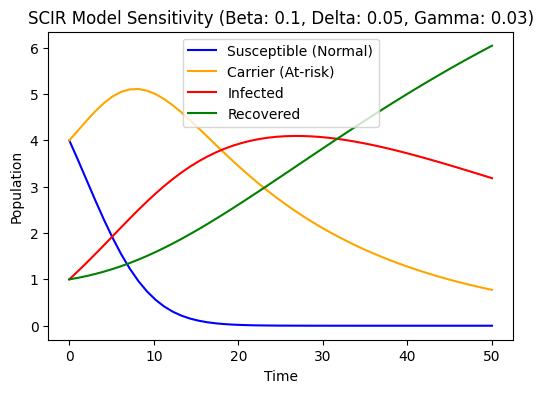

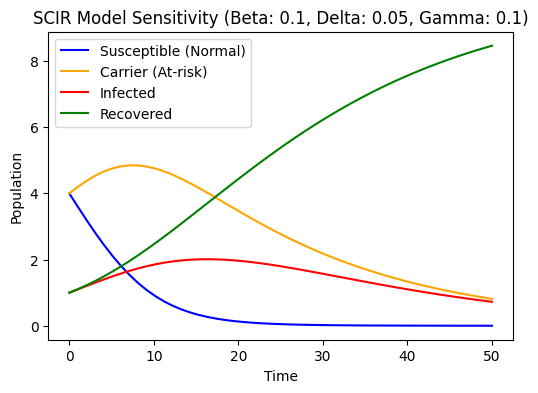

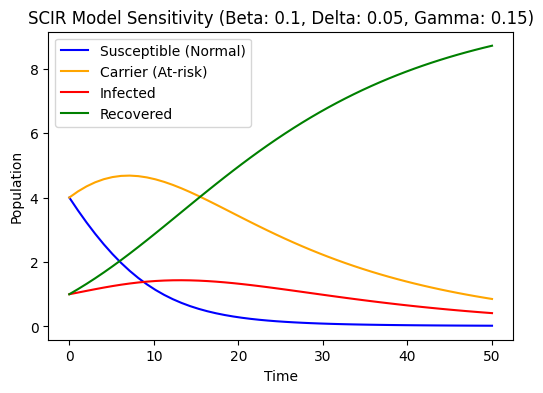

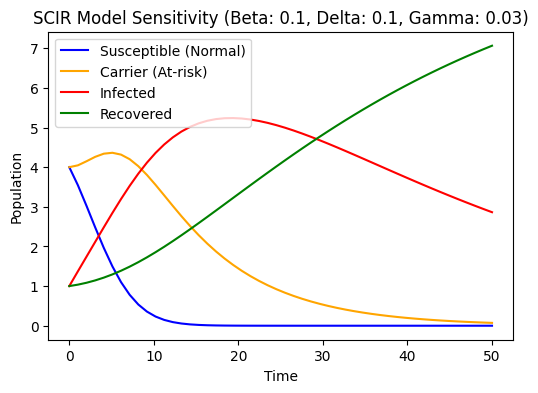

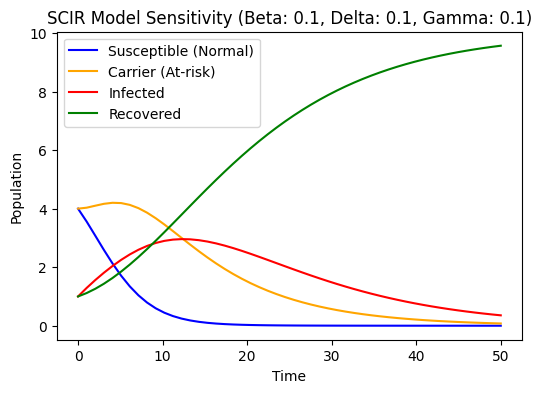

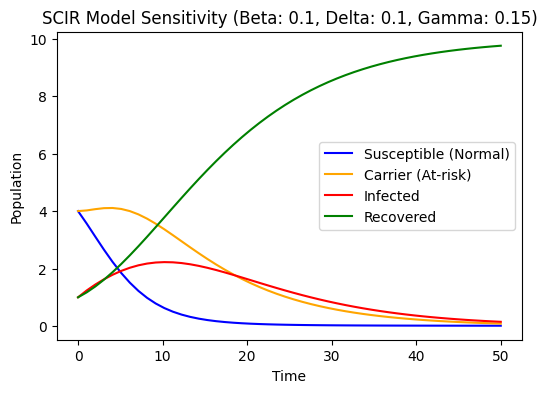

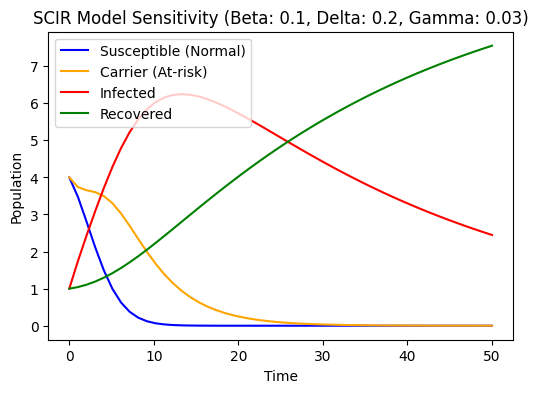

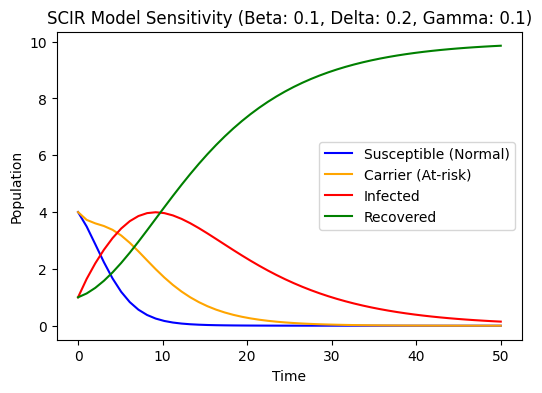

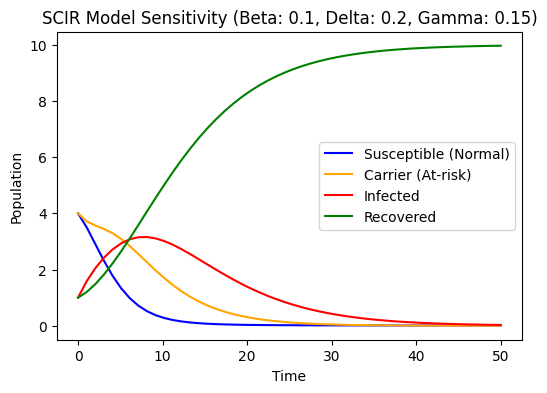

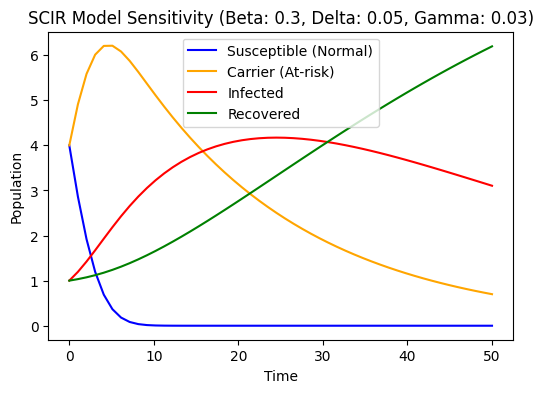

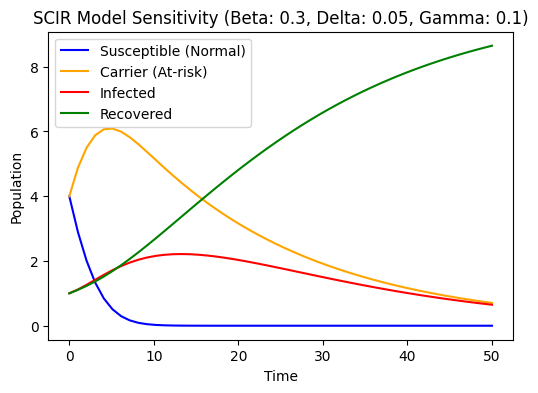

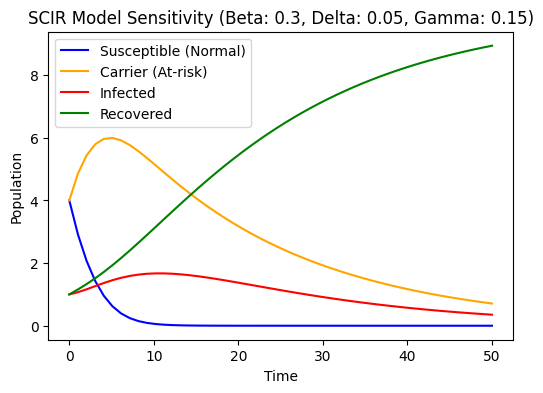

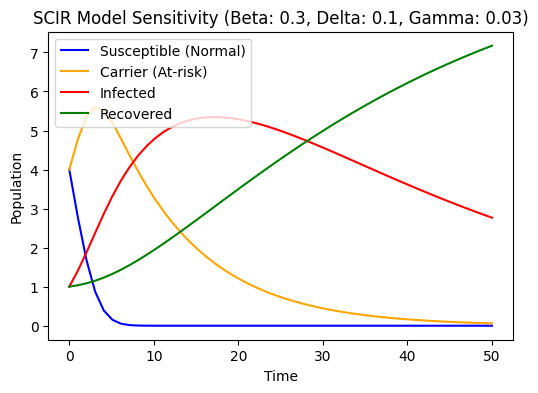

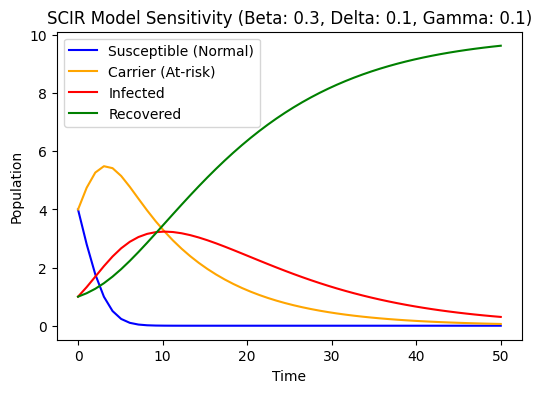

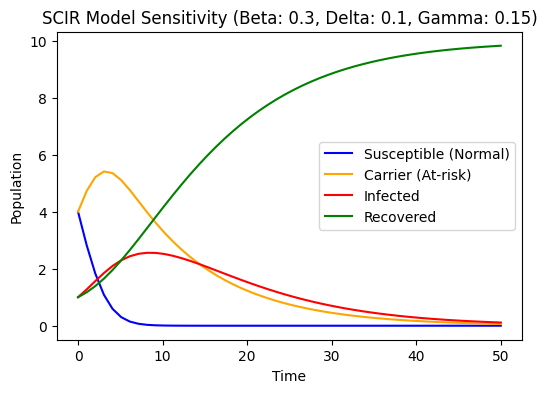

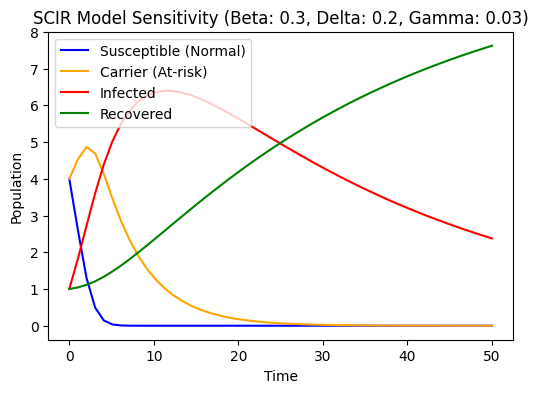

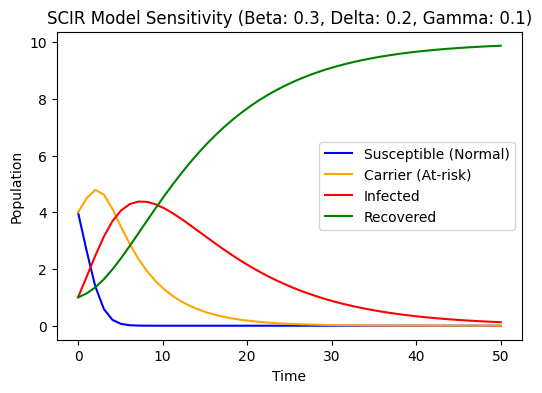

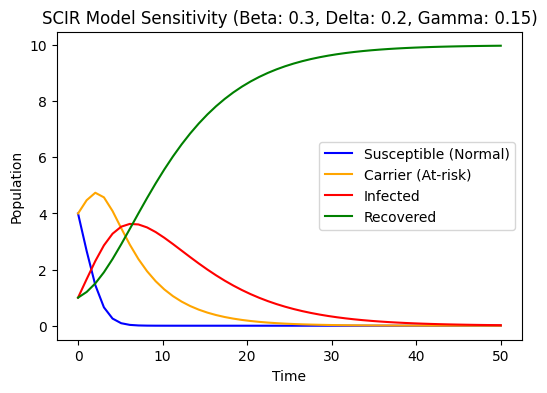

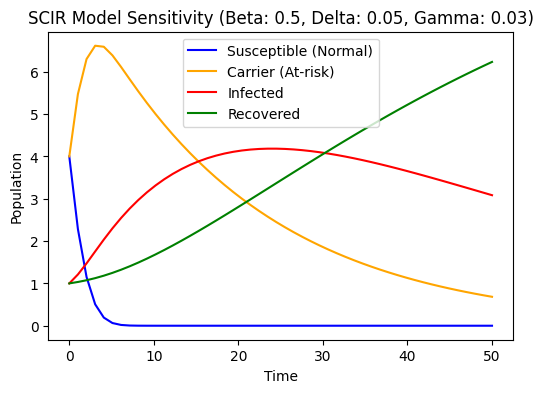

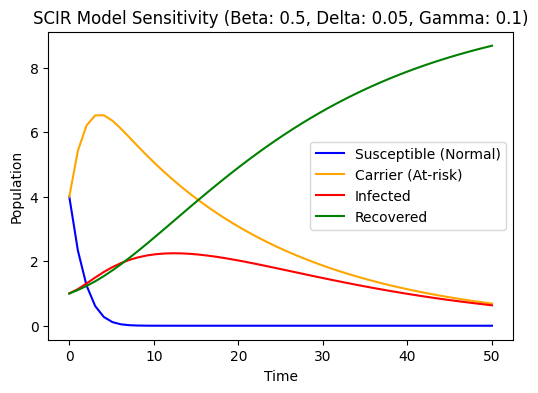

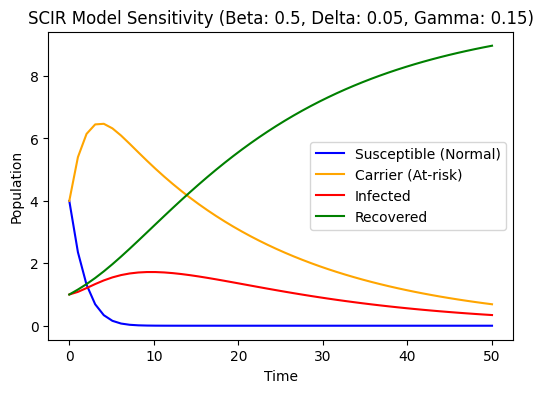

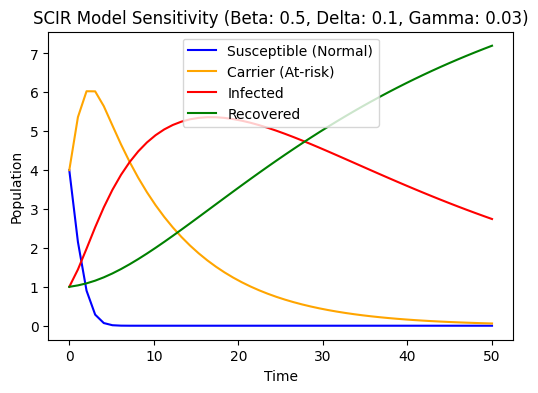

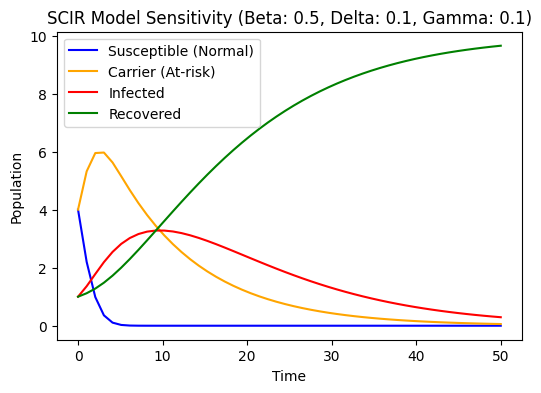

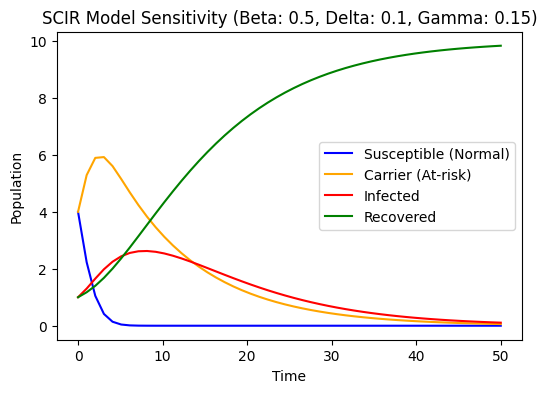

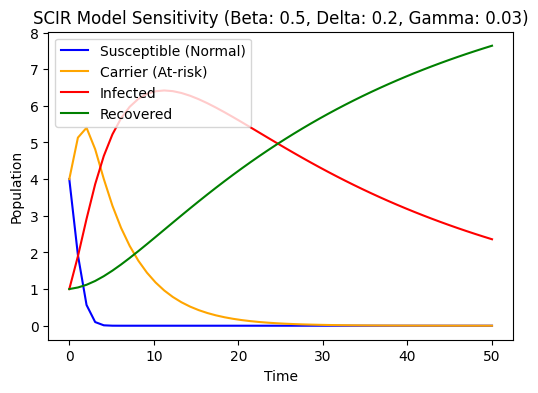

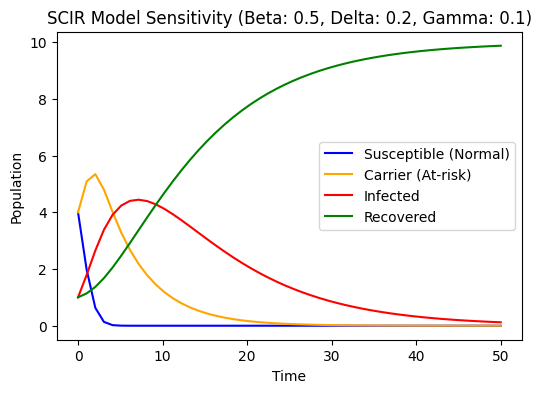

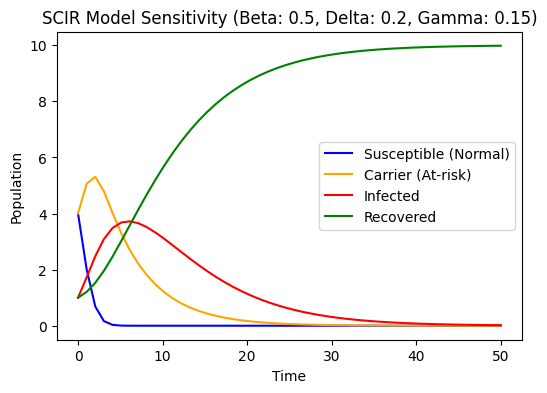

In [8]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

# Define SCIR model differential equations
def scir_model(y, t, beta, delta, gamma):
    S, C, I, R = y
    dSdt = -beta * S * I
    dCdt = beta * S * I - delta * C
    dIdt = delta * C - gamma * I
    dRdt = gamma * I
    return [dSdt, dCdt, dIdt, dRdt]

# Initial population counts from classifications
S0 = initial_states["Susceptible"]
C0 = initial_states["Carrier"]
I0 = initial_states["Infected"]
R0 = initial_states["Recovered"]
y0 = [S0, C0, I0, R0]  # Initial conditions

# Time points for the simulation (e.g., 50 time steps)
t = np.linspace(0, 50, 50)

# Sensitivity analysis parameters for SCIR transitions
beta_values = [0.1, 0.3, 0.5]   # Transition rate from Susceptible to Carrier
delta_values = [0.05, 0.1, 0.2]  # Transition rate from Carrier to Infected
gamma_values = [0.03, 0.1, 0.15] # Transition rate from Infected to Recovered

# Perform sensitivity analysis by varying beta, delta, and gamma
for beta in beta_values:
    for delta in delta_values:
        for gamma in gamma_values:
            solution = odeint(scir_model, y0, t, args=(beta, delta, gamma))
            S, C, I, R = solution.T  # Transpose solution to get separate arrays

            # Plot results for each combination
            plt.figure(figsize=(6, 4))
            plt.plot(t, S, label="Susceptible (Normal)", color="blue")
            plt.plot(t, C, label="Carrier (At-risk)", color="orange")
            plt.plot(t, I, label="Infected", color="red")
            plt.plot(t, R, label="Recovered", color="green")
            plt.xlabel("Time")
            plt.ylabel("Population")
            plt.title(f"SCIR Model Sensitivity (Beta: {beta}, Delta: {delta}, Gamma: {gamma})")
            plt.legend()
            plt.show()

In [9]:
from scipy.integrate import odeint
import numpy as np
import pandas as pd

# Define SCIR model differential equations
def scir_model(y, t, beta, delta, gamma):
    S, C, I, R = y
    dSdt = -beta * S * I
    dCdt = beta * S * I - delta * C
    dIdt = delta * C - gamma * I
    dRdt = gamma * I
    return [dSdt, dCdt, dIdt, dRdt]

# Initial population counts from classifications
S0 = initial_states["Susceptible"]
C0 = initial_states["Carrier"]
I0 = initial_states["Infected"]
R0 = initial_states["Recovered"]
y0 = [S0, C0, I0, R0]  # Initial conditions

# Time points for the simulation (e.g., 50 time steps)
t = np.linspace(0, 50, 50)

# Sensitivity analysis parameters for SCIR transitions
beta_values = [0.1, 0.3, 0.5]   # Transition rate from Susceptible to Carrier
delta_values = [0.05, 0.1, 0.2]  # Transition rate from Carrier to Infected
gamma_values = [0.03, 0.1, 0.15] # Transition rate from Infected to Recovered

# DataFrame to store results
results = []

# Perform sensitivity analysis by varying beta, delta, and gamma
for beta in beta_values:
    for delta in delta_values:
        for gamma in gamma_values:
            solution = odeint(scir_model, y0, t, args=(beta, delta, gamma))
            S, C, I, R = solution.T  # Transpose solution to get separate arrays

            # Save results for this parameter combination
            for i, time_point in enumerate(t):
                results.append({
                    "Time": time_point,
                    "Beta": beta,
                    "Delta": delta,
                    "Gamma": gamma,
                    "Susceptible (S)": S[i],
                    "Carrier (C)": C[i],
                    "Infected (I)": I[i],
                    "Recovered (R)": R[i],
                })

# Convert results to a DataFrame
df_results = pd.DataFrame(results)

# Display the DataFrame (or save to a CSV file for further analysis)
print(df_results)

# Optionally save to CSV
df_results.to_csv("scir_sensitivity_analysis.csv", index=False)

           Time  Beta  Delta  Gamma  Susceptible (S)  Carrier (C)  \
0      0.000000   0.1   0.05   0.03     4.000000e+00     4.000000   
1      1.020408   0.1   0.05   0.03     3.579824e+00     4.210763   
2      2.040816   0.1   0.05   0.03     3.145853e+00     4.424429   
3      3.061224   0.1   0.05   0.03     2.713039e+00     4.626278   
4      4.081633   0.1   0.05   0.03     2.295164e+00     4.803470   
...         ...   ...    ...    ...              ...          ...   
1345  45.918367   0.5   0.20   0.15     2.659801e-12     0.000943   
1346  46.938776   0.5   0.20   0.15     2.618096e-12     0.000769   
1347  47.959184   0.5   0.20   0.15     2.582639e-12     0.000627   
1348  48.979592   0.5   0.20   0.15     2.552443e-12     0.000511   
1349  50.000000   0.5   0.20   0.15     2.526690e-12     0.000417   

      Infected (I)  Recovered (R)  
0         1.000000       1.000000  
1         1.176119       1.033294  
2         1.357656       1.072063  
3         1.544216       1.